In [9]:
# --- Load extracted features dataset ---

import pandas as pd
import joblib

# Option 1: Load CSV
# features = pd.read_csv("../processed_data/extracted_features.csv")

# Option 2 (faster): Load pickle
features = joblib.load("../processed_data/extracted_features.pkl")

print("Loaded feature dataset successfully!")
print("Shape:", features.shape)
print("Columns:", features.columns.tolist()[:10], "...")
print("Activities:", features['activity'].unique())
print("Recordings:", features['source_file'].nunique())
features.head()


Loaded feature dataset successfully!
Shape: (749, 54)
Columns: ['acc_x_mean', 'acc_x_std', 'acc_x_var', 'acc_x_min', 'acc_x_max', 'acc_x_median', 'acc_y_mean', 'acc_y_std', 'acc_y_var', 'acc_y_min'] ...
Activities: ['jump' 'standing' 'still' 'walk']
Recordings: 50


,acc_x_mean,acc_x_std,acc_x_var,acc_x_min,acc_x_max,acc_x_median,acc_y_mean,acc_y_std,acc_y_var,acc_y_min,...,acc_z_dom_freq,acc_z_spec_energy,gyro_x_dom_freq,gyro_x_spec_energy,gyro_y_dom_freq,gyro_y_spec_energy,gyro_z_dom_freq,gyro_z_spec_energy,activity,source_file
0,-0.021524,0.667775,0.445924,-1.849218,0.855231,0.140855,0.132795,0.539499,0.291060,-1.061096,...,1.0,40979.881514,0.5,842.854959,1.5,958.867761,2.5,127.407510,jump,jump_01_merged.csv
1,0.020366,0.927388,0.860049,-1.849218,1.821961,-0.248110,-0.162298,1.221100,1.491085,-2.501738,...,1.0,136381.085362,1.0,2812.576757,1.5,5819.880819,2.5,405.852354,jump,jump_01_merged.csv
2,0.318321,0.980550,0.961478,-2.890957,1.821961,0.547057,-0.040576,2.428427,5.897259,-6.293818,...,1.0,160602.088884,1.0,5133.171877,1.0,5757.219448,2.5,866.949533,jump,jump_01_merged.csv
3,0.148123,1.552531,2.410352,-5.404576,2.651305,0.485997,-0.014619,2.769314,7.669098,-8.253015,...,1.0,173011.721633,1.0,9763.992689,4.0,3286.689986,4.5,1790.809594,jump,jump_01_merged.csv
4,0.428056,1.757772,3.089764,-5.404576,3.503008,0.811033,-0.556027,2.507469,6.287402,-8.253015,...,1.0,295681.735834,3.5,10148.071948,4.5,6786.838483,4.5,3202.846257,jump,jump_01_merged.csv


### Feature Engineering Rationale
We derived 42 accelerometer and gyroscope statistics per window to expose both quasi-static postures and dynamic motion signatures:
- **Time-domain shape:** axis-wise mean, variance, standard deviation, extrema, and median quantify bias, amplitude, and spread; `acc_SMA` summarizes overall magnitude; inter-axis correlations capture posture-dependent coupling (e.g., steady standing keeps axes aligned, jumping injects cross-axis correlation).
- **Frequency-domain rhythm:** dominant frequency and spectral energy for each axis reveal periodic patterns that distinguish cyclic walking from nearly static stillness; gyroscope spectra highlight angular bursts caused by jumps.
- **Normalization:** we apply Z-score scaling so Baum–Welch treats heterogeneous units (m/s² vs rad/s) uniformly, preventing high-variance axes from overwhelming the Gaussian emissions. The scaler parameters are fitted on the training split only to avoid leakage.

In [10]:
# --- Summarize feature categories ---
feature_columns = [col for col in features.columns if col not in ["activity", "source_file"]]
time_keywords = ["mean", "std", "var", "min", "max", "median", "SMA", "corr"]
freq_keywords = ["dom_freq", "spec_energy"]

def classify_feature(col: str) -> str:
    if any(k in col for k in freq_keywords):
        return "frequency-domain"
    if any(k in col for k in time_keywords):
        return "time-domain"
    return "other"

feature_overview = (
    pd.DataFrame({
        "feature": feature_columns,
        "category": [classify_feature(col) for col in feature_columns]
    })
    .assign(axis=lambda df: df["feature"].str.extract(r"^(acc|gyro)_"))
)

category_counts = feature_overview.groupby(["category", "axis"]).size().unstack(fill_value=0)
category_counts

axis,acc,gyro
category,,
frequency-domain,6,6
time-domain,22,18


In [11]:
# --- Prepare label encoder and feature list ---

from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from typing import List, Tuple

LABEL_COL = "activity"
GROUP_COL = "source_file"
feature_columns = [col for col in features.columns if col not in [LABEL_COL, GROUP_COL]]

le = LabelEncoder()
le.fit(features[LABEL_COL])

print("Label encoding:", dict(zip(le.classes_, le.transform(le.classes_))))
print(f"Total feature columns: {len(feature_columns)}")

Label encoding: {'jump': 0, 'standing': 1, 'still': 2, 'walk': 3}
Total feature columns: 52


In [12]:
# --- Utility helpers for data splits and scaling ---
def split_by_recording(df: pd.DataFrame, group_col: str = GROUP_COL, test_ratio: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    """Split the dataset into train/test partitions using entire recordings."""
    rng = np.random.default_rng(random_state)
    files = df[group_col].unique().copy()
    rng.shuffle(files)

    split_index = int((1 - test_ratio) * len(files))
    train_files = files[:split_index]
    test_files = files[split_index:]

    train_df = df[df[group_col].isin(train_files)].reset_index(drop=True)
    test_df = df[df[group_col].isin(test_files)].reset_index(drop=True)
    return train_df, test_df, train_files, test_files

def scale_features(train_df: pd.DataFrame, test_df: pd.DataFrame, feature_cols: List[str]) -> Tuple[StandardScaler, np.ndarray, np.ndarray]:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[feature_cols])
    X_test = scaler.transform(test_df[feature_cols])
    return scaler, X_train, X_test

In [13]:
# --- Split into training and testing sets by recording ---

train_df, test_df, train_files, test_files = split_by_recording(
    features, group_col=GROUP_COL, test_ratio=0.2, random_state=42
 )

print(f"Training recordings: {len(train_files)}, Testing recordings: {len(test_files)}")
print("Training files:", sorted(train_files)[:5], "...")
print("Testing files:", sorted(test_files)[:5], "...")

scaler, X_train, X_test = scale_features(train_df, test_df, feature_columns)
y_train = le.transform(train_df[LABEL_COL])
y_test = le.transform(test_df[LABEL_COL])

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training recordings: 40, Testing recordings: 10
Training files: ['jump_04_merged.csv', 'jump_05_merged.csv', 'jump_06_merged.csv', 'jump_07_merged.csv', 'jump_08_merged.csv'] ...
Testing files: ['jump_01_merged.csv', 'jump_02_merged.csv', 'jump_03_merged.csv', 'jump_09_merged.csv', 'standing_02_merged.csv'] ...
Training set shape: (592, 52)
Testing set shape: (157, 52)
Training set shape: (592, 52)
Testing set shape: (157, 52)


In [14]:
# --- Train the Hidden Markov Model (HMM) ---

from hmmlearn import hmm

def train_hmm(
    X: np.ndarray,
    n_states: int,
    covariance_type: str = "diag",
    n_iter: int = 200,
    tol: float = 1e-3,
    random_state: int = 42,
    verbose: bool = False,
 ) -> Tuple[hmm.GaussianHMM, List[float]]:
    """Fit a Gaussian HMM and return the fitted model plus log-likelihood trace."""
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type=covariance_type,
        n_iter=n_iter,
        tol=tol,
        random_state=random_state,
        verbose=verbose,
    )
    model.fit(X)
    log_likelihood_trace = list(model.monitor_.history)
    return model, log_likelihood_trace

n_states = len(le.classes_)
model, log_likelihood_trace = train_hmm(
    X_train, n_states=n_states, covariance_type="diag", n_iter=200, tol=1e-3, random_state=42
)

print("Number of states (activities):", n_states)
print("HMM converged:", model.monitor_.converged)
print("Iterations used:", model.monitor_.iter)
print("Final log-likelihood:", model.monitor_.history[-1])
print("\nHMM training completed successfully!")

Number of states (activities): 4
HMM converged: True
Iterations used: 14
Final log-likelihood: 18966.57409709547

HMM training completed successfully!


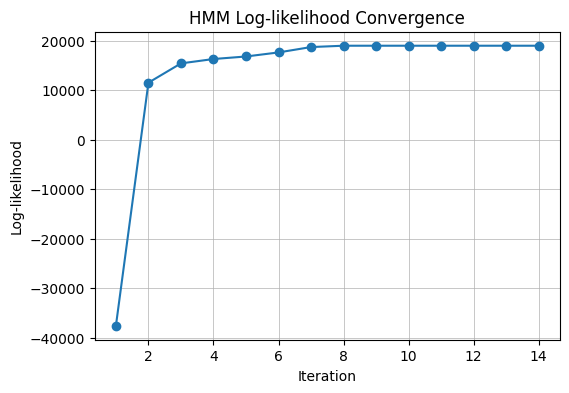

In [15]:
# --- Inspect Baum–Welch convergence ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(log_likelihood_trace) + 1), log_likelihood_trace, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("HMM Log-likelihood Convergence")
plt.grid(True, linewidth=0.5)
plt.show()

In [16]:
# --- Decode sequences using Viterbi algorithm ---

logprob_train, states_train = model.decode(X_train, algorithm="viterbi")

# Map HMM states to activity labels (majority vote)
mapping = {}
for state in range(n_states):
    idx = np.where(states_train == state)[0]
    if len(idx) > 0:
        majority_label = np.argmax(np.bincount(y_train[idx]))
        mapping[state] = majority_label
    else:
        mapping[state] = -1

print("State → label mapping:", mapping)


State → label mapping: {0: 0, 1: 3, 2: 2, 3: 1}


In [17]:
# --- Evaluate HMM on unseen data ---

if len(test_files) < 2:
    print("Warning: less than two recordings in the test split; consider reserving additional sessions for evaluation.")
logprob_test, states_test = model.decode(X_test, algorithm="viterbi")
y_pred = np.array([mapping.get(s, -1) for s in states_test])

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=range(n_states))
report = classification_report(y_test, y_pred, target_names=le.classes_, digits=3)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

def compute_activity_metrics(cm_matrix: np.ndarray) -> pd.DataFrame:
    """Compute per-class sensitivity, specificity, and accuracy from a confusion matrix."""
    totals = cm_matrix.sum()
    metrics = []
    for idx, label in enumerate(le.classes_):
        tp = cm_matrix[idx, idx]
        fn = cm_matrix[idx, :].sum() - tp
        fp = cm_matrix[:, idx].sum() - tp
        tn = totals - (tp + fn + fp)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        accuracy = (tp + tn) / totals if totals > 0 else np.nan
        metrics.append({
            "activity": label,
            "samples": int(cm_matrix[idx, :].sum()),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "overall_accuracy": accuracy,
        })
    return pd.DataFrame(metrics)

metrics_df = compute_activity_metrics(cm)
metrics_df

Confusion Matrix:
 [[61  0  0  0]
 [ 0 44  0  2]
 [ 0  0 35  0]
 [ 0  0  0 15]]

Classification Report:
               precision    recall  f1-score   support

        jump      1.000     1.000     1.000        61
    standing      1.000     0.957     0.978        46
       still      1.000     1.000     1.000        35
        walk      0.882     1.000     0.938        15

    accuracy                          0.987       157
   macro avg      0.971     0.989     0.979       157
weighted avg      0.989     0.987     0.988       157



,activity,samples,sensitivity,specificity,overall_accuracy
0,jump,61,1.000000,1.000000,1.000000
1,standing,46,0.956522,1.000000,0.987261
2,still,35,1.000000,1.000000,1.000000
3,walk,15,1.000000,0.985915,0.987261


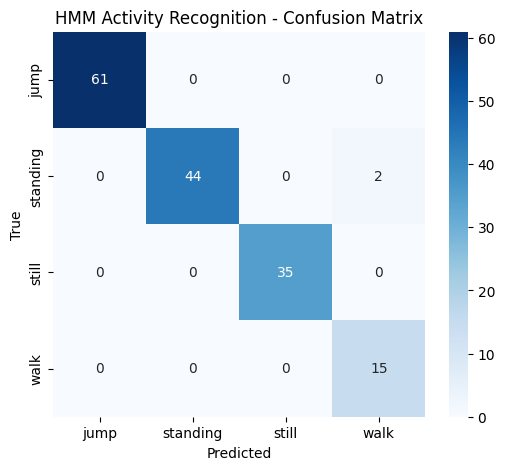

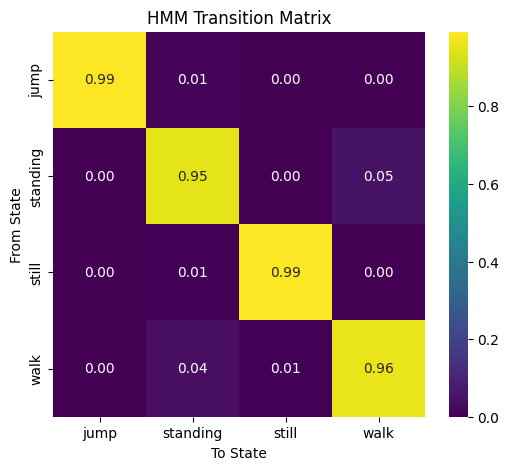

In [18]:
# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("HMM Activity Recognition - Confusion Matrix")
plt.show()

# Transition matrix
plt.figure(figsize=(6,5))
sns.heatmap(model.transmat_, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("To State")
plt.ylabel("From State")
plt.title("HMM Transition Matrix")
plt.show()


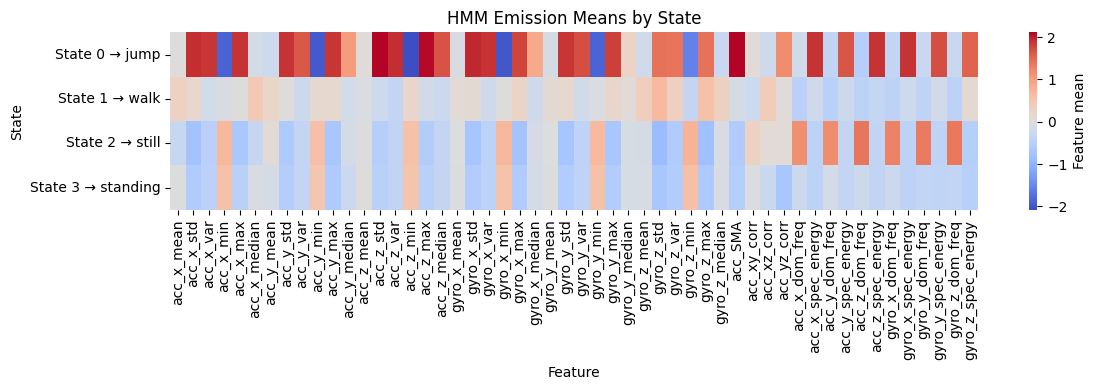

In [ ]:
# Emission (state mean) heatmap
emission_df = pd.DataFrame(model.means_, columns=feature_columns)
state_annotations = []
for state_idx in range(n_states):
    mapped_label_idx = mapping.get(state_idx, -1)
    if mapped_label_idx == -1:
        state_annotations.append(f"State {state_idx}")
    else:
        state_annotations.append(f"State {state_idx} → {le.classes_[mapped_label_idx]}")
emission_df.index = state_annotations

plt.figure(figsize=(12, 4))
sns.heatmap(emission_df, cmap="coolwarm", center=0, cbar_kws={"label": "Feature mean"})
plt.xlabel("Feature")
plt.ylabel("State")
plt.title("HMM Emission Means by State")
plt.tight_layout()
plt.show()

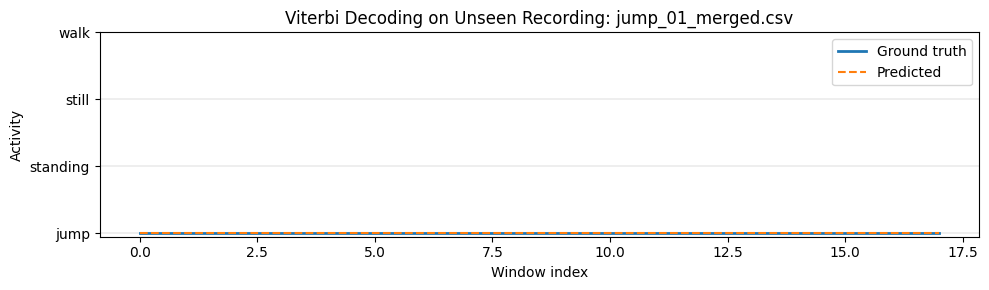

In [20]:
# --- Visualize decoded activity sequence on an unseen recording ---
if len(test_files) > 0:
    sample_file = sorted(test_files)[0]
    sample_df = test_df[test_df[GROUP_COL] == sample_file]
    X_sample = scaler.transform(sample_df[feature_columns])
    _, sample_states = model.decode(X_sample, algorithm="viterbi")
    decoded_labels = []
    for state_id in sample_states:
        mapped_idx = mapping.get(state_id, -1)
        decoded_labels.append(le.classes_[mapped_idx] if mapped_idx != -1 else "unmapped")
    activity_to_int = {label: idx for idx, label in enumerate(le.classes_)}
    true_indices = sample_df[LABEL_COL].map(activity_to_int).to_numpy()
    pred_indices = np.array([activity_to_int.get(lbl, np.nan) for lbl in decoded_labels])

    plt.figure(figsize=(10, 3))
    plt.step(range(len(true_indices)), true_indices, where="post", label="Ground truth", linewidth=2)
    plt.step(range(len(pred_indices)), pred_indices, where="post", label="Predicted", linestyle="--")
    plt.yticks(list(activity_to_int.values()), list(activity_to_int.keys()))
    plt.xlabel("Window index")
    plt.ylabel("Activity")
    plt.title(f"Viterbi Decoding on Unseen Recording: {sample_file}")
    plt.legend()
    plt.grid(True, axis="y", linewidth=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No held-out recordings available for sequence visualization.")

In [21]:
# --- Save trained model & encoders ---
import joblib
joblib.dump({
    "model": model,
    "scaler": scaler,
    "label_encoder": le,
    "mapping": mapping,
    "feature_columns": feature_columns,
    "log_likelihood_trace": log_likelihood_trace,
    "train_files": train_files.tolist(),
    "test_files": test_files.tolist(),
}, "../processed_data/hmm_trained_model.pkl")
print("Saved trained model to '../processed_data/hmm_trained_model.pkl'")

Saved trained model to '../processed_data/hmm_trained_model.pkl'
